In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data preparation

In [3]:
images_metadata_dataframe = pd.read_csv("./images_metadata.csv")
images_metadata_dataframe["relative_x"] = images_metadata_dataframe["x"] / images_metadata_dataframe["image_width"]
images_metadata_dataframe["relative_y"] = images_metadata_dataframe["y"] / images_metadata_dataframe["image_height"]
df = pd.DataFrame({
    "relative_x":images_metadata_dataframe["relative_x"], 
    "relative_y":images_metadata_dataframe["relative_y"]
})

### Check whether objects prefer some location to others

    - No

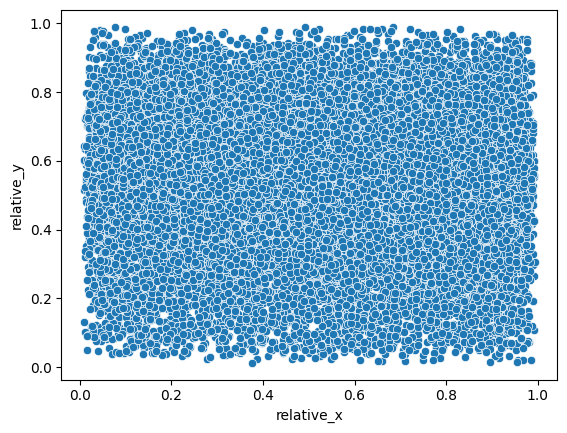

In [6]:
sns.scatterplot(data=df, x="relative_x", y="relative_y")
plt.show()

### Data preparation

In [7]:
grid_size = 7 
filenames = images_metadata_dataframe["filename"].unique()
images_have_position_conflict = []
objects_have_position_conflict = []

### Check iamges which has position conflict problem that a grid cell contains more than one object

    - The idea is from yoloV1's shortages

In [9]:
for filename in filenames:
    grids = np.zeros((grid_size, grid_size))
    display_columns = ["relative_x", "relative_y"]
    rx_rys = images_metadata_dataframe[display_columns][images_metadata_dataframe.filename==filename]
    rx_rys = rx_rys.to_numpy()
    for rx_ry in rx_rys:
        rx = rx_ry[0]
        ry = rx_ry[1]
        # Confirm the location of an object
        row = int(ry * grid_size)
        col = int(rx * grid_size)
        grids[row][col] += 1
    # If one cell contains at least 2 objects, this image has position conflict problem
    if np.sum((grids >= 2)) > 0:
        images_have_position_conflict.append(filename)

### Findings

    - 1926 (11.25%) images have position conflict problems
    

In [10]:
print(f"{len(images_have_position_conflict)} images have position conflict")
print(f"{round(len(images_have_position_conflict) / len(filenames) * 100, 2)}% images have position conflict")

1926 images have position conflict
11.25% images have position conflict


### Display the objects position conflict from 3 problem images on scatterplot 

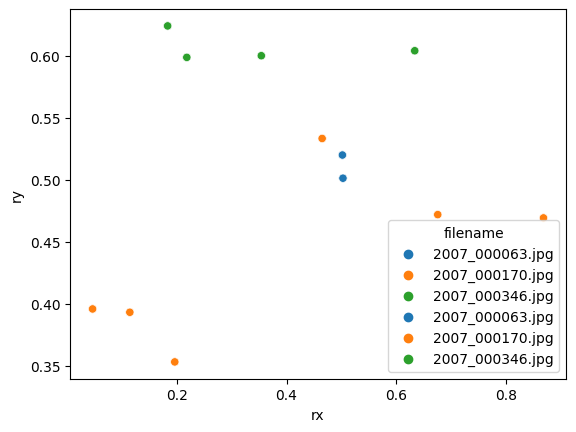

In [12]:
rxs = []
rys = []
classes = []
filenames = []
for filename in images_have_position_conflict[0:3]:
    display_columns = ["relative_x", "relative_y", "class", "filename"]
    rx_ry_class_filenames = images_metadata_dataframe[display_columns][images_metadata_dataframe.filename==filename].to_numpy()
    for rx_ry_class_filename in rx_ry_class_filenames:
        rxs.append(rx_ry_class_filename[0])
        rys.append(rx_ry_class_filename[1])
        classes.append(rx_ry_class_filename[2])
        filenames.append(rx_ry_class_filename[3])
df = pd.DataFrame({"rx":rxs, "ry":rys, "class":classes, "filename":filenames})
ax = sns.scatterplot(data=df, x="rx", y="ry", hue="filename")
plt.show()

### How many objects those position conflict problems images on average contain

    - 6

In [13]:
display_column = "class"
counts = []
for filename in images_have_position_conflict:
    count = len(images_metadata_dataframe[display_column][images_metadata_dataframe.filename==filename])
    counts.append(count)
print(np.mean(counts))

6.484942886812045


### How many cell only contains same class objects and how many cell contains objects with different class

    - 1730 cells contain same class objects
    - 1088 cells contain different class objects

In [14]:
conflict_objects = []
for filename in images_have_position_conflict:
    conflict_objects_dict = {}
    conflict_objects_dict_keys = []
    grids = np.zeros((grid_size, grid_size))
    display_columns = ["relative_x", "relative_y", "class"]
    rx_rys_classes = images_metadata_dataframe[display_columns][images_metadata_dataframe.filename==filename]
    rx_rys_classes = rx_rys_classes.to_numpy()
    for rx_ry_class in rx_rys_classes:
        rx = rx_ry_class[0]
        ry = rx_ry_class[1]
        _class_ = rx_ry_class[2]
        # Confirm the location of an object
        row = int(ry * grid_size)
        col = int(rx * grid_size)
        # row+(row+1)*col is just using location as unique identifier
        if row+(row+1)*col in conflict_objects_dict:
            conflict_objects_dict[row+(row+1)*col].append(_class_)
        else:
            conflict_objects_dict[row+(row+1)*col] = [_class_]
        grids[row][col] += 1
        if grids[row][col] >= 2:
            if row+(row+1)*col not in conflict_objects_dict_keys:
                conflict_objects_dict_keys.append(row+(row+1)*col)
    for key in conflict_objects_dict_keys:
        conflict_objects.append(conflict_objects_dict[key])

In [15]:
cells_with_only_same_class_objects = []
cells_with_different_class_objects = []
for conflict_object in conflict_objects:
    if len(np.unique(conflict_object)) > 1:
        cells_with_different_class_objects.append(conflict_object)
    else:
        cells_with_only_same_class_objects.append(conflict_object)

In [16]:
print(f"{len(cells_with_only_same_class_objects)} cells contain same class objects")
print(f"{len(cells_with_different_class_objects)} cells contain different class objects")

1730 cells contain same class objects
1088 cells contain different class objects


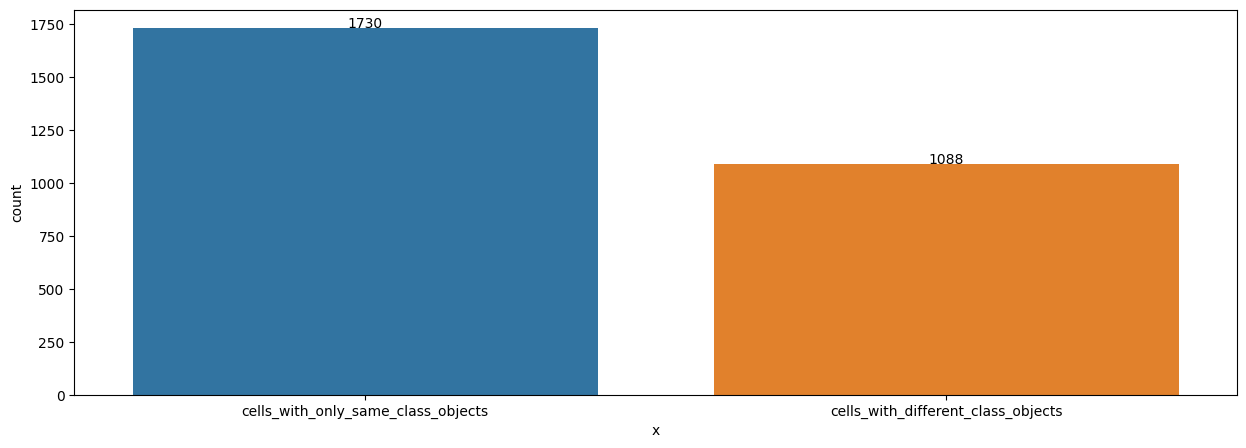

In [17]:
counts = [len(cells_with_only_same_class_objects), len(cells_with_different_class_objects)]
df = pd.DataFrame({"x": ["cells_with_only_same_class_objects", "cells_with_different_class_objects"],
                   "count": counts})
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="x", y="count", data=df)
for i in range(len(counts)):
    ax.text(i, counts[i], counts[i], color='black', ha="center")
plt.show()

### Yolo shortages analysis with two anchor boxes

#### The number of objects will be ignored in training
    same_class_objects_count - len(cells_with_only_same_class_objects) + different_class_objects_count - len(cells_with_different_class_objects)
    
#### The number of objects cannot be detected in evaluation
    same_class_objects_count - 2*len(cells_with_only_same_class_objects) + different_class_objects_count - 2*len(cells_with_different_class_objects)
    
#### The number of objects will be incorrectly classified in evaluation
    1/2 * different_class_objects_count

In [19]:
same_class_objects_count = []
different_class_objects_count = []
for cell_with_only_same_class_objects in cells_with_only_same_class_objects:
    same_class_objects_count.append(len(cell_with_only_same_class_objects))
for cell_with_different_class_objects in cells_with_different_class_objects:
    different_class_objects_count.append(len(cell_with_different_class_objects))

In [20]:
objects_count = len(images_metadata_dataframe)
same_class_objects_count = np.sum(same_class_objects_count)
cells_with_only_same_class_objects_count = len(cells_with_only_same_class_objects)
different_class_objects_count = np.sum(different_class_objects_count)
cells_with_different_class_objects_count = len(cells_with_different_class_objects)

In [21]:
percentage_objects_be_ignored_training = (same_class_objects_count - cells_with_only_same_class_objects_count + \
                                         different_class_objects_count - cells_with_different_class_objects_count) / objects_count
percentage_objects_be_ignored_evaluation = (same_class_objects_count - 2*cells_with_only_same_class_objects_count + \
                                         different_class_objects_count - 2*cells_with_different_class_objects_count) / objects_count
percentage_objects_be_incorrectly_classified_evaluation = 0.5 * different_class_objects_count / objects_count

percentage_objects_be_ignored_training = round(percentage_objects_be_ignored_training, 2)
percentage_objects_be_ignored_evaluation = round(percentage_objects_be_ignored_evaluation, 2)
percentage_objects_be_incorrectly_classified_evaluation = round(percentage_objects_be_incorrectly_classified_evaluation, 2)

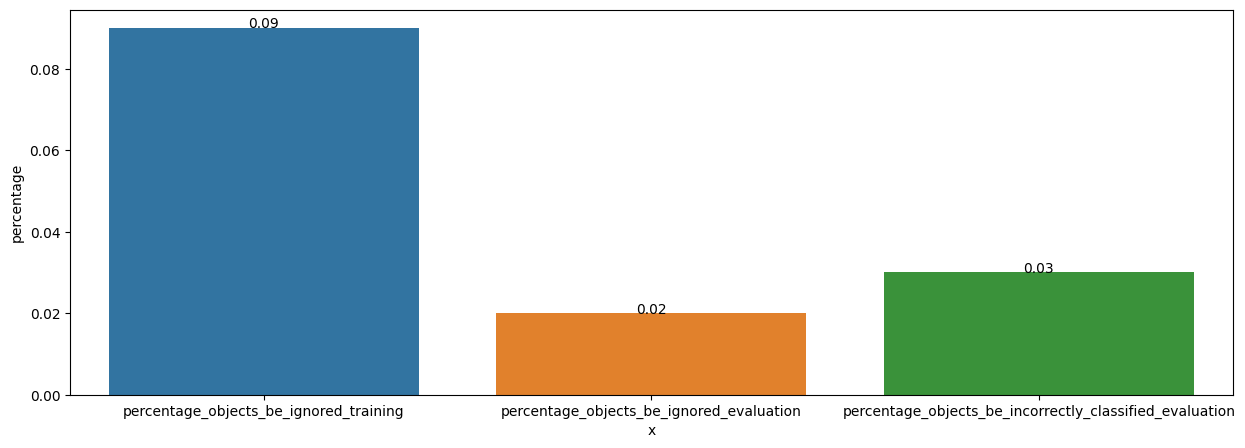

In [22]:
percentages = [percentage_objects_be_ignored_training, 
               percentage_objects_be_ignored_evaluation,
               percentage_objects_be_incorrectly_classified_evaluation]
df = pd.DataFrame({"x": ["percentage_objects_be_ignored_training", 
                         "percentage_objects_be_ignored_evaluation",
                         "percentage_objects_be_incorrectly_classified_evaluation"],
                   "percentage": percentages})
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="x", y="percentage", data=df)
for i in range(len(percentages)):
    ax.text(i, percentages[i], percentages[i], color='black', ha="center")
plt.show()

### The top 5 same objects in cells and top 5 different objects in cells 

In [23]:
same_class_objects = []
different_class_objects = []
for cell_with_only_same_class_objects in cells_with_only_same_class_objects:
    for o in cell_with_only_same_class_objects:
        same_class_objects.append(o)
for cell_with_different_class_objects in cells_with_different_class_objects:
    for o in cell_with_different_class_objects:
        different_class_objects.append(o)

In [24]:
same_class_objects = pd.Series(same_class_objects, name="same_class_objects")
different_class_objects = pd.Series(different_class_objects, name="different_class_objects")

In [25]:
same_class_objects = same_class_objects.value_counts()
different_class_objects = different_class_objects.value_counts()

In [26]:
df = pd.DataFrame({
    "status": ["same_class_objects"]*20 + ["different_class_objects"]*20,
    "count": list(same_class_objects) + [0] + list(different_class_objects),
    "object": list(same_class_objects.index) + ["sofa"] + list(different_class_objects.index)
})

C:\Users\c2038737\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


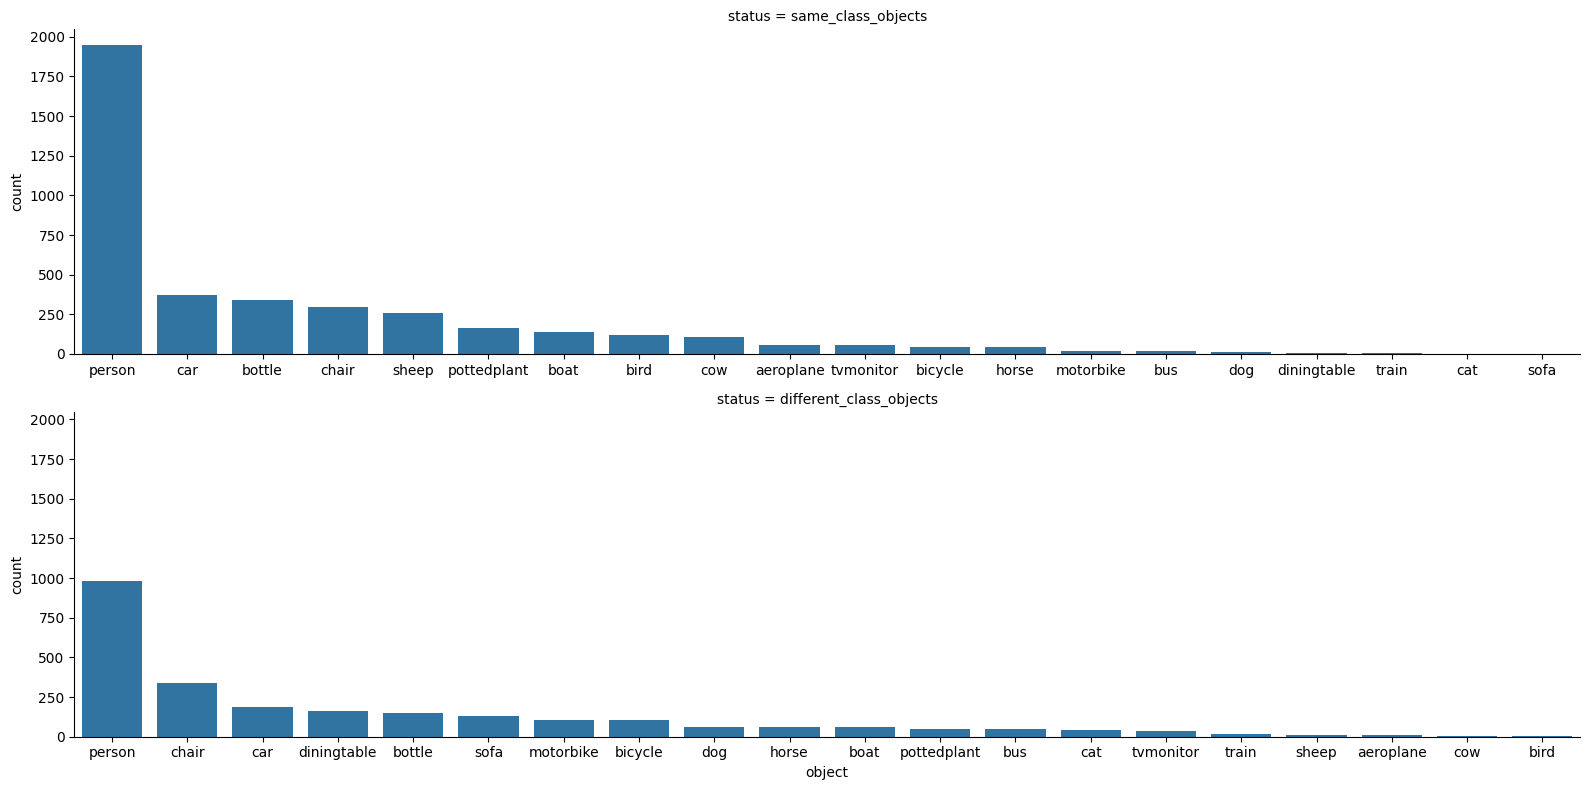

In [30]:
g = sns.FacetGrid(df, row="status", 
                  height=4, aspect=4,sharex=False)
g_map = g.map(sns.barplot, "object", "count")
plt.show()